In [16]:
import json
import pandas as pd

repo_profiles = {}
with open('repo_profiles.json') as rj:
    for rl in rj.readlines():
        line = rl.split('\t')
        repo = line[0]
        profile = json.loads(line[1])
        repo_profiles[repo] = profile
    
team_profiles = []
teams = []
with open('team_profiles.json') as tj:
    for tl in tj.readlines():
        line = tl.split('\t')
        team = json.loads(line[0])
        profile = json.loads(line[1])
        team_profiles.append(profile)
        teams.append(team)

In [17]:
repo_profiles_df = pd.DataFrame(repo_profiles).transpose()
repo_profiles_df.fillna('',inplace=True)
team_profiles_df = pd.DataFrame(team_profiles,index=[str(t) for t in teams])
team_profiles_df.rename(columns={
                                   'repo_size':'size',
                                   'repo_forks':'forks',
                                   'repo_subscribers':'subscribers',
                                   'repo_watchers':'watchers',
                                   'languages':'languages',
                                   'topics':'topics'
                               },inplace=True)

numerics = ['size','forks','subscribers','watchers']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013E8763E710>,
      dtype=object)

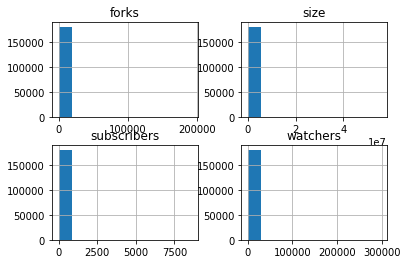

In [18]:
repo_profiles_df[numerics].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013E833D0390>,
      dtype=object)

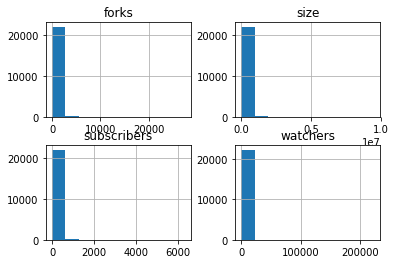

In [19]:
team_profiles_df[numerics].hist()

In [15]:
min = repo_profiles_df[numerics].min()
max = repo_profiles_df[numerics].max()
repo_profiles_df[numerics] = (repo_profiles_df[numerics]-min)/(max-min)
team_profiles_df[numerics] = (team_profiles_df[numerics]-min)/(max-min)

print(repo_profiles_df.iloc[0])
print(team_profiles_df.iloc[0])

forks                                                2.60891e-05
languages                                                       
size                                                   9.597e-05
subscribers                                            0.0037357
topics         [oxygenxml, git, oxygen-standalone-plugin, add...
watchers                                             8.08912e-05
Name: oxygenxml/oxygen-git-plugin, dtype: object
languages      [HTML, CSS, Python, JavaScript]
forks                              0.000122619
size                               2.99895e-05
subscribers                         0.00192622
watchers                           0.000128078
topics                                      []
Name: ['AMorporkian', 'kharidiron'], dtype: object


In [3]:
repo_profiles_df.describe()

,forks,size,subscribers,watchers
count,181323.000000,181323.000000,181323.000000,181323.000000
mean,0.000539,0.001451,0.004377,0.001476
std,0.003829,0.010532,0.015398,0.008520
min,0.000000,0.000000,0.000000,0.000000
25%,0.000005,0.000011,0.000350,0.000000
50%,0.000078,0.000072,0.001401,0.000044
75%,0.000297,0.000483,0.003736,0.000509
max,1.000000,1.000000,1.000000,1.000000


In [4]:
team_profiles_df.describe()

,forks,size,subscribers,watchers
count,22330.000000,2.233000e+04,22330.000000,22330.000000
mean,0.001999,1.710201e-03,0.011510,0.004689
std,0.004260,4.203524e-03,0.020819,0.014758
min,0.000000,3.429433e-07,0.000000,0.000000
25%,0.000245,1.999221e-04,0.002815,0.000240
50%,0.000789,6.011164e-04,0.005915,0.001209
75%,0.002131,1.573824e-03,0.012524,0.004808
max,0.143161,1.714984e-01,0.736896,0.750063


In [5]:
import numpy as np

def euclidean_distance(p1,p2):
    distance = np.linalg.norm(p1[numerics]-p2[numerics])**2
    langs = set(p1['languages']).union(p2['languages'])
    topics = set(p1['topics']).union(p2['topics'])
    p1_langs = pd.Series([lang in p1['languages'] for lang in langs])/np.sqrt(len(langs))
    p2_langs = pd.Series([lang in p2['languages'] for lang in langs])/np.sqrt(len(langs))
    p1_topics = pd.Series([topic in p1['topics'] for topic in topics])/np.sqrt(len(topics))
    p2_topics = pd.Series([topic in p2['topics'] for topic in topics])/np.sqrt(len(topics))
    distance += np.linalg.norm(p1_langs-p2_langs)**2 + np.linalg.norm(p1_topics-p2_topics)**2
    distance = np.sqrt(distance)
    
    return distance
    
p1 = repo_profiles_df.iloc[0]
p2 = team_profiles_df.iloc[0]
print(euclidean_distance(p1,p2))

1.4142147256033752


In [6]:
from queue import PriorityQueue

team_recommendations = []
cnt = 0
for repo,repo_profile in repo_profiles_df.iterrows():
    cnt += 1
    if cnt > 10:
        break
    print(cnt)
    rec = []
    queue = PriorityQueue()
    for team,team_profile in team_profiles_df.iterrows():
        dis = euclidean_distance(repo_profile,team_profile)
        queue.put_nowait((-dis,team))
        if queue.qsize() > 20:
            queue.get_nowait()
    while queue.qsize()>0:
        rec.append(queue.get_nowait())
    team_recommendations.append(rec)


1
2
3
4
5
6
7
8
9
10


In [7]:
for i,rec in enumerate(team_recommendations):
    print(repo_profiles_df.iloc[i].name,end='\t')
    for tm in rec:
        print(tm,end='\t')
    print('\n')

oxygenxml/oxygen-git-plugin	(-1.0000000073497037, "['tspenov', 'LucoLe']")	(-1.0000000056802527, "['tiagoshibata', 'ppathan', 'spryor', 'avanikp', 'mechaffin', 'isaac73', 'hathind-ms']")	(-1.0000000038092847, "['JoanClaret', 'PablitoGS', 'nguasch', 'beatrizip', 'siscu']")	(-0.9929359497256668, "['kivervinicius', 'shadowmaru', 'alinebastos', 'khaosdoctor', 'WendellAdriel', 'wilcorrea', 'angeliski', 'mikaelhadler', 'adeonir', 'giovannicruz97', 'lbighetti', 'lflimeira', 'kellfluz', 'Diego-Brocanelli', 'pacheco7']")	(-0.9746798367656732, "['Hx66', 'mkruijt', 'Razpudding', 'ChrisOwen101', 'fversnel', 'eidosam']")	(-0.9661029323122489, "['MartinHelmut', 'kotzendekrabbe', 'Alexpeschel']")	(-0.9636280149061522, "['arjunkharbanda', '2jiwon', 'SamirJouni', 'ktran031', 'dimitristsaknakis']")	(-0.963625899760768, "['rabinrai44', 'aneagoie', 'thisisabdus', 'drood87', 'MattCSmith', 'juliangilquin', 'skylar01', 'tonydc1997']")	(-0.9607725975606737, "['alexanmtz', 'mthais', 'lucianojfj']")	(-0.9607694